In [6]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

In [7]:
import xgboost as xgb
from imblearn.over_sampling import SMOTE
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import joblib

In [8]:
df = pd.read_csv("dummydata.csv")  # Replace with your CSV path
print(f"✅ Original dataset shape: {df.shape}")

✅ Original dataset shape: (187, 79)


In [9]:
print(df.columns.tolist())


['Destination Port', ' Flow Duration', ' Total Fwd Packets', ' Total Backward Packets', 'Total Length of Fwd Packets', ' Total Length of Bwd Packets', ' Fwd Packet Length Max', ' Fwd Packet Length Min', ' Fwd Packet Length Mean', ' Fwd Packet Length Std', 'Bwd Packet Length Max', ' Bwd Packet Length Min', ' Bwd Packet Length Mean', ' Bwd Packet Length Std', 'Flow Bytes/s', ' Flow Packets/s', ' Flow IAT Mean', ' Flow IAT Std', ' Flow IAT Max', ' Flow IAT Min', 'Fwd IAT Total', ' Fwd IAT Mean', ' Fwd IAT Std', ' Fwd IAT Max', ' Fwd IAT Min', 'Bwd IAT Total', ' Bwd IAT Mean', ' Bwd IAT Std', ' Bwd IAT Max', ' Bwd IAT Min', 'Fwd PSH Flags', ' Bwd PSH Flags', ' Fwd URG Flags', ' Bwd URG Flags', ' Fwd Header Length', ' Bwd Header Length', 'Fwd Packets/s', ' Bwd Packets/s', ' Min Packet Length', ' Max Packet Length', ' Packet Length Mean', ' Packet Length Std', ' Packet Length Variance', 'FIN Flag Count', ' SYN Flag Count', ' RST Flag Count', ' PSH Flag Count', ' ACK Flag Count', ' URG Flag C

In [10]:
# Strip leading/trailing spaces from all columns
df.columns = df.columns.str.strip()

# Now check columns again
print(df.columns.tolist())


['Destination Port', 'Flow Duration', 'Total Fwd Packets', 'Total Backward Packets', 'Total Length of Fwd Packets', 'Total Length of Bwd Packets', 'Fwd Packet Length Max', 'Fwd Packet Length Min', 'Fwd Packet Length Mean', 'Fwd Packet Length Std', 'Bwd Packet Length Max', 'Bwd Packet Length Min', 'Bwd Packet Length Mean', 'Bwd Packet Length Std', 'Flow Bytes/s', 'Flow Packets/s', 'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Max', 'Flow IAT Min', 'Fwd IAT Total', 'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Max', 'Fwd IAT Min', 'Bwd IAT Total', 'Bwd IAT Mean', 'Bwd IAT Std', 'Bwd IAT Max', 'Bwd IAT Min', 'Fwd PSH Flags', 'Bwd PSH Flags', 'Fwd URG Flags', 'Bwd URG Flags', 'Fwd Header Length', 'Bwd Header Length', 'Fwd Packets/s', 'Bwd Packets/s', 'Min Packet Length', 'Max Packet Length', 'Packet Length Mean', 'Packet Length Std', 'Packet Length Variance', 'FIN Flag Count', 'SYN Flag Count', 'RST Flag Count', 'PSH Flag Count', 'ACK Flag Count', 'URG Flag Count', 'CWE Flag Count', 'ECE Flag Count

In [11]:
important_cols = [
    "Destination Port","Flow Duration",
    "Total Fwd Packets","Total Backward Packets",
    "Total Length of Fwd Packets","Total Length of Bwd Packets",
    "Fwd Packet Length Mean","Fwd Packet Length Std",
    "Bwd Packet Length Mean","Bwd Packet Length Std",
    "Flow Bytes/s","Flow Packets/s",
    "Flow IAT Mean","Flow IAT Std",
    "Fwd IAT Mean","Bwd IAT Mean",
    "FIN Flag Count","SYN Flag Count","RST Flag Count","PSH Flag Count",
    "ACK Flag Count","URG Flag Count",
    "Fwd Header Length","Bwd Header Length",
    "Fwd Packets/s","Bwd Packets/s",
    "Min Packet Length","Max Packet Length","Packet Length Mean","Packet Length Std",
    "Average Packet Size","Avg Fwd Segment Size","Avg Bwd Segment Size",
    "Init_Win_bytes_forward","Init_Win_bytes_backward",
    "Active Mean","Idle Mean",
    "Label"
]

df = df[important_cols]
print(f"✅ Dataset shape with important columns: {df.shape}")


✅ Dataset shape with important columns: (187, 38)


In [12]:
# Make a copy to avoid SettingWithCopyWarning
df = df.copy()

# Replace inf/-inf with NaN
df.replace([np.inf, -np.inf], np.nan, inplace=True)

# Drop rows with NaN
df.dropna(inplace=True)


In [13]:
# Step 4: Encode Labels
# -------------------------------
le = LabelEncoder()
df['Label'] = le.fit_transform(df['Label'])
joblib.dump(le, "label_encoder.pkl")
print(f"✅ Classes: {list(le.classes_)}")

✅ Classes: ['BENIGN', 'DDoS', 'DoS Hulk', 'PortScan', 'R2L', 'U2R']


In [14]:
# Rare classes by name (String labels BEFORE encoding)
rare_classes = ["R2L", "U2R"]  

# Convert to encoded values
rare_labels = le.transform(rare_classes)
print("Encoded rare class labels:", rare_labels)

# Extract rows of rare samples
rare_data = df[df["Label"].isin(rare_labels)]
print(f"🔍 Rare class data shape: {rare_data.shape}")


Encoded rare class labels: [4 5]
🔍 Rare class data shape: (6, 38)


In [15]:
from sdv.metadata import SingleTableMetadata
from sdv.single_table import CTGANSynthesizer

if rare_data.shape[0] > 1:
    metadata = SingleTableMetadata()
    metadata.detect_from_dataframe(data=rare_data)

    ctgan = CTGANSynthesizer(metadata, epochs=300)
    ctgan.fit(rare_data)

    # Generate 5× synthetic data
    synthetic_data = ctgan.sample(len(rare_data) * 5)

    # Add to dataset
    df = pd.concat([df, synthetic_data], ignore_index=True)
    print(f"🚀 Final dataset after CTGAN augmentation: {df.shape}")

else:
    print("⚠️ CTGAN skipped — too few rare class samples.")


c:\Users\DELL\anaconda3\envs\IntrusionDetection\Lib\site-packages\sdv\single_table\base.py:168: FutureWarning: The 'SingleTableMetadata' is deprecated. Please use the new 'Metadata' class for synthesizers.
  warnings.warn(DEPRECATION_MSG, FutureWarning)
c:\Users\DELL\anaconda3\envs\IntrusionDetection\Lib\site-packages\sdv\single_table\base.py:134: UserWarning: We strongly recommend saving the metadata using 'save_to_json' for replicability in future SDV versions.
  warnings.warn(


🚀 Final dataset after CTGAN augmentation: (217, 38)


In [16]:
from imblearn.over_sampling import SMOTE

X = df.drop('Label', axis=1)
y = df['Label']

smote = SMOTE(random_state=42)
X_bal, y_bal = smote.fit_resample(X, y)

print(f"✔ After SMOTE: {X_bal.shape}")


✔ After SMOTE: (300, 37)


In [18]:
train_df = pd.DataFrame(X_bal, columns=X.columns)
train_df['Label'] = y_bal

train_df.to_csv("train_preprocessed.csv", index=False)
print("💾 Final dataset saved as train_preprocessed.csv")


💾 Final dataset saved as train_preprocessed.csv


In [19]:
from sklearn.model_selection import train_test_split

df = pd.read_csv("train_preprocessed.csv")

X = df.drop("Label", axis=1)
y = df["Label"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)

# OPTIONAL: Save separately
train_df = pd.concat([X_train, y_train], axis=1)
test_df = pd.concat([X_test, y_test], axis=1)
train_df.to_csv("train_final.csv", index=False)
test_df.to_csv("test_final.csv", index=False)

print("💾 train_final.csv and test_final.csv saved.")


Train shape: (240, 37)
Test shape: (60, 37)
💾 train_final.csv and test_final.csv saved.


In [43]:
# Step 5: Scale the Data (IMPORTANT STEP)
from sklearn.preprocessing import StandardScaler
import joblib

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)   # Fit ONLY on training data
X_test_scaled = scaler.transform(X_test)         # Transform test data

# Save scaler for future use (frontend / testing)
joblib.dump(scaler, "newscaler.pkl")
print("💾 Saved newscaler.pkl")

# Convert back to DataFrame for model training
X_train = pd.DataFrame(X_train_scaled, columns=X.columns)
X_test = pd.DataFrame(X_test_scaled, columns=X.columns)


💾 Saved newscaler.pkl


In [44]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

def plot_conf_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=le.classes_,
                yticklabels=le.classes_)
    plt.title(title)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()
    print(classification_report(y_true, y_pred, target_names=le.classes_))


In [45]:
import xgboost as xgb

dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

params = {
    "objective": "multi:softmax",
    "num_class": len(y.unique()),
    "eval_metric": "mlogloss",
    "max_depth": 6,
    "eta": 0.3
}

xgb_model = xgb.train(params, dtrain, num_boost_round=100)
xgb_model.save_model("xgboost_model.json")   # Save model

# Predict
xgb_pred = xgb_model.predict(dtest)

print("\n=== XGBoost ===")
print(classification_report(y_test, xgb_pred))



=== XGBoost ===
              precision    recall  f1-score   support

           0       1.00      0.90      0.95        10
           1       0.91      1.00      0.95        10
           2       1.00      1.00      1.00        10
           3       1.00      1.00      1.00        10
           4       1.00      1.00      1.00        10
           5       1.00      1.00      1.00        10

    accuracy                           0.98        60
   macro avg       0.98      0.98      0.98        60
weighted avg       0.98      0.98      0.98        60




=== Confusion Matrix (XGBoost) ===
[[ 9  1  0  0  0  0]
 [ 0 10  0  0  0  0]
 [ 0  0 10  0  0  0]
 [ 0  0  0 10  0  0]
 [ 0  0  0  0 10  0]
 [ 0  0  0  0  0 10]]


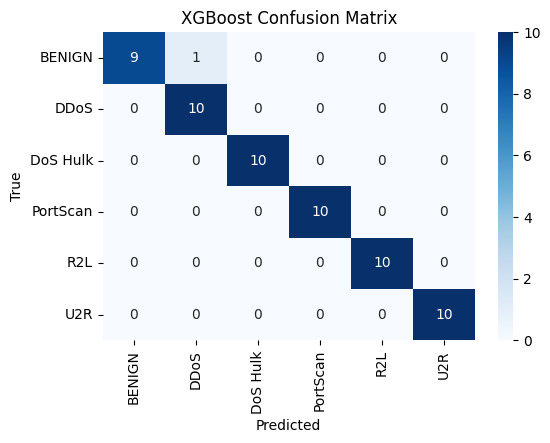

In [46]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# ------------ CONFUSION MATRIX ---------------
cm = confusion_matrix(y_test, xgb_pred)
print("\n=== Confusion Matrix (XGBoost) ===")
print(cm)

# Plot it
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=le.classes_,
            yticklabels=le.classes_)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("XGBoost Confusion Matrix")
plt.show()


In [47]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
import joblib

rf = RandomForestClassifier(n_estimators=200, random_state=42)
rf.fit(X_train, y_train)

# Save model
joblib.dump(rf, "random_forest_model.pkl")

# Evaluate
rf_pred = rf.predict(X_test)
print("\n=== Random Forest ===")
print(classification_report(y_test, rf_pred))



=== Random Forest ===
              precision    recall  f1-score   support

           0       1.00      0.90      0.95        10
           1       1.00      1.00      1.00        10
           2       0.91      1.00      0.95        10
           3       1.00      1.00      1.00        10
           4       1.00      0.90      0.95        10
           5       0.91      1.00      0.95        10

    accuracy                           0.97        60
   macro avg       0.97      0.97      0.97        60
weighted avg       0.97      0.97      0.97        60



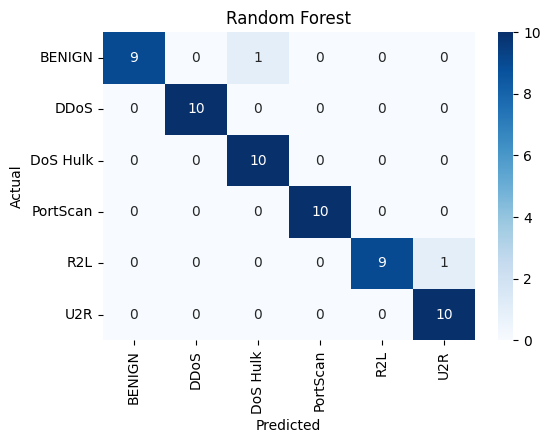

              precision    recall  f1-score   support

      BENIGN       1.00      0.90      0.95        10
        DDoS       1.00      1.00      1.00        10
    DoS Hulk       0.91      1.00      0.95        10
    PortScan       1.00      1.00      1.00        10
         R2L       1.00      0.90      0.95        10
         U2R       0.91      1.00      0.95        10

    accuracy                           0.97        60
   macro avg       0.97      0.97      0.97        60
weighted avg       0.97      0.97      0.97        60



In [48]:
y_pred_rf = rf.predict(X_test)
plot_conf_matrix(y_test, y_pred_rf, "Random Forest")


In [49]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, MaxPooling1D, Flatten

# Reshape for CNN
X_train_DL = X_train.values.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test_DL  = X_test.values.reshape((X_test.shape[0], X_test.shape[1], 1))

# Build CNN
cnn = Sequential([
    Conv1D(64, 3, activation='relu', input_shape=(X_train.shape[1], 1)),
    MaxPooling1D(2),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(len(y.unique()), activation='softmax')   # output layer
])

cnn.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
cnn.summary()

# Train
cnn.fit(X_train_DL, y_train, epochs=20, batch_size=32, verbose=1)

# Save CNN
cnn.save("cnn_model.keras")

# Evaluate
loss, acc = cnn.evaluate(X_test_DL, y_test)
print(f"\n=== CNN RESULTS ===\nAccuracy: {acc:.4f}")


c:\Users\DELL\anaconda3\envs\IntrusionDetection\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_5 (Conv1D)               │ (None, 35, 64)         │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_5 (MaxPooling1D)  │ (None, 17, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 1088)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 64)             │        69,696 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 6)              │           390 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 70,342 (274.77 KB)

 Trainable params: 70,342 (274.77 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5125 - loss: 1.4133
Epoch 2/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7333 - loss: 0.8590 
Epoch 3/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7625 - loss: 0.6112 
Epoch 4/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8292 - loss: 0.4846 
Epoch 5/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8500 - loss: 0.4006 
Epoch 6/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8667 - loss: 0.3611
Epoch 7/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8750 - loss: 0.3148 
Epoch 8/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8792 - loss: 0.2933 
Epoch 9/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8833 - loss: 0.2757 
Epoch 10/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8833 - loss: 0.2660 
Epoch 11/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8958 - loss: 0.2564  
Epoch 12/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8792 - loss: 0.2515 
E

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


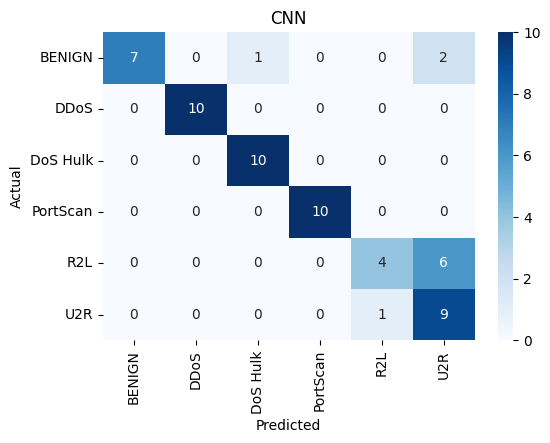

              precision    recall  f1-score   support

      BENIGN       1.00      0.70      0.82        10
        DDoS       1.00      1.00      1.00        10
    DoS Hulk       0.91      1.00      0.95        10
    PortScan       1.00      1.00      1.00        10
         R2L       0.80      0.40      0.53        10
         U2R       0.53      0.90      0.67        10

    accuracy                           0.83        60
   macro avg       0.87      0.83      0.83        60
weighted avg       0.87      0.83      0.83        60



In [51]:
X_test_cnn = np.expand_dims(X_test.values, axis=2)  # reshape for CNN
y_pred_cnn = cnn.predict(X_test_cnn).argmax(axis=1)
plot_conf_matrix(y_test, y_pred_cnn, "CNN")


In [52]:
from sklearn.metrics import accuracy_score, f1_score
# If you trained using DMatrix method:
y_pred_xgb = xgb_model.predict(dtest)  # <-- must be defined first!

models = ["Random Forest", "XGBoost", "CNN"]
accuracies = [
    accuracy_score(y_test, y_pred_rf),
    accuracy_score(y_test, y_pred_xgb),
    accuracy_score(y_test, y_pred_cnn)
]
f1_scores = [
    f1_score(y_test, y_pred_rf, average='macro'),
    f1_score(y_test, y_pred_xgb, average='macro'),
    f1_score(y_test, y_pred_cnn, average='macro')
]

import pandas as pd
results_df = pd.DataFrame({
    "Model": models,
    "Accuracy": accuracies,
    "F1 Score": f1_scores
})

print(results_df)


           Model  Accuracy  F1 Score
0  Random Forest  0.966667  0.966583
1        XGBoost  0.983333  0.983292
2            CNN  0.833333  0.829318


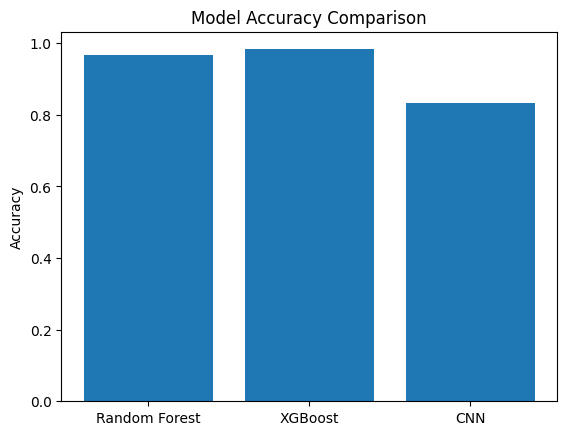

In [53]:
import matplotlib.pyplot as plt

plt.bar(models, accuracies)
plt.title("Model Accuracy Comparison")
plt.ylabel("Accuracy")
plt.show()


In [ ]:
#testing

In [54]:
import joblib
import xgboost as xgb
from tensorflow.keras.models import load_model

# Load models
rf_model = joblib.load("random_forest_model.pkl")
xgb_model = xgb.Booster()
xgb_model.load_model("xgboost_model.json")
cnn_model = load_model("cnn_model.keras")

# Load label encoder
le = joblib.load("label_encoder.pkl")
import pandas as pd
import numpy as np

# Load your test CSV (same columns as training)
test_df = pd.read_csv("test_final.csv")  # Put your test file here

# Same preprocessing as training
test_df = test_df.replace([np.inf, -np.inf], np.nan).dropna()

X_test_new = test_df.drop("Label", axis=1, errors="ignore")
rf_pred = rf_model.predict(X_test_new)
print("🎯 Random Forest Prediction:", le.inverse_transform(rf_pred))
dtest_new = xgb.DMatrix(X_test_new)
xgb_pred = xgb_model.predict(dtest_new)
print("🚀 XGBoost Prediction:", le.inverse_transform(xgb_pred.astype(int)))
# Reshape like before
# Use this only if cnn_model.input_shape = (None, 37, 1)
X_test_cnn = np.array(X_test_new).reshape(X_test_new.shape[0], X_test_new.shape[1], 1)

cnn_pred = cnn_model.predict(X_test_cnn)
cnn_pred = np.argmax(cnn_pred, axis=1)

print("🧠 CNN-LSTM Prediction:", le.inverse_transform(cnn_pred))



🎯 Random Forest Prediction: ['DoS Hulk' 'DoS Hulk' 'DoS Hulk' 'DoS Hulk' 'DoS Hulk' 'DoS Hulk'
 'DoS Hulk' 'DoS Hulk' 'DoS Hulk' 'DDoS' 'DoS Hulk' 'DoS Hulk' 'DoS Hulk'
 'DoS Hulk' 'DoS Hulk' 'DoS Hulk' 'DoS Hulk' 'DoS Hulk' 'DoS Hulk'
 'DoS Hulk' 'DoS Hulk' 'DoS Hulk' 'DoS Hulk' 'DoS Hulk' 'DoS Hulk'
 'DoS Hulk' 'DoS Hulk' 'DoS Hulk' 'DoS Hulk' 'DoS Hulk' 'DoS Hulk'
 'DoS Hulk' 'DoS Hulk' 'DoS Hulk' 'DoS Hulk' 'DoS Hulk' 'DoS Hulk'
 'DoS Hulk' 'DoS Hulk' 'DoS Hulk' 'DoS Hulk' 'DoS Hulk' 'DoS Hulk'
 'DoS Hulk' 'DoS Hulk' 'DoS Hulk' 'DoS Hulk' 'DoS Hulk' 'DoS Hulk'
 'DoS Hulk' 'DoS Hulk' 'DoS Hulk' 'DoS Hulk' 'DoS Hulk' 'DoS Hulk'
 'DoS Hulk' 'DoS Hulk' 'DoS Hulk' 'DoS Hulk' 'DoS Hulk']
🚀 XGBoost Prediction: ['DoS Hulk' 'DoS Hulk' 'DoS Hulk' 'DoS Hulk' 'DoS Hulk' 'DoS Hulk'
 'DoS Hulk' 'DoS Hulk' 'DoS Hulk' 'R2L' 'DoS Hulk' 'DoS Hulk' 'DoS Hulk'
 'DoS Hulk' 'DoS Hulk' 'DoS Hulk' 'DoS Hulk' 'DoS Hulk' 'DoS Hulk'
 'DoS Hulk' 'DoS Hulk' 'DoS Hulk' 'DoS Hulk' 'DoS Hulk' 'DoS Hulk'
 'DoS Hul